# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip

In [42]:
import torch
from utils import plot_training, precompute_features, train
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

dir_path = "data/TP4_images/"

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [43]:
base_model.fc = nn.Linear(512, 2)

In [44]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

  2%|▏         | 11/500 [00:00<00:04, 104.08it/s]

Epoch 1, train loss: 0.6898, test loss: 1.2882, accuracy: 0.5000


 23%|██▎       | 113/500 [00:01<00:03, 98.99it/s] 

Epoch 101, train loss: 0.2294, test loss: 0.9663, accuracy: 0.4762


 44%|████▍     | 221/500 [00:02<00:02, 106.65it/s]

Epoch 201, train loss: 0.1273, test loss: 0.9366, accuracy: 0.5476


 63%|██████▎   | 315/500 [00:03<00:01, 112.29it/s]

Epoch 301, train loss: 0.0943, test loss: 1.0154, accuracy: 0.5952


 85%|████████▍ | 423/500 [00:04<00:00, 111.22it/s]

Epoch 401, train loss: 0.0662, test loss: 1.1884, accuracy: 0.5714


100%|██████████| 500/500 [00:04<00:00, 106.06it/s]


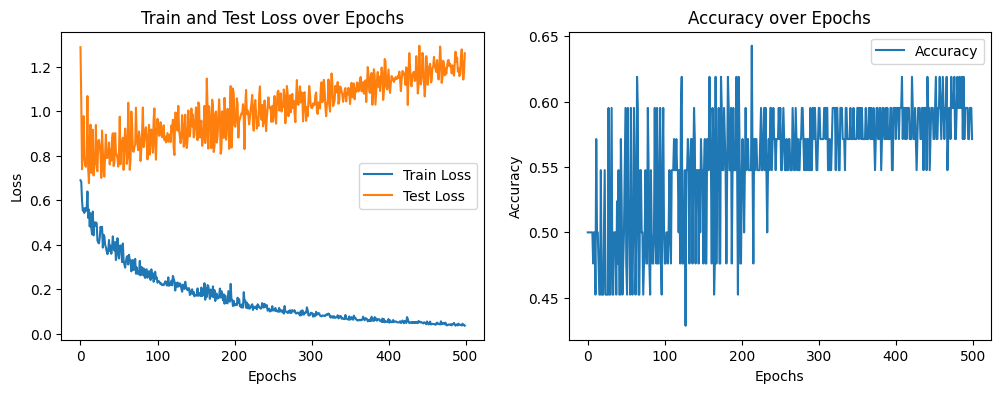

In [45]:
from copy import deepcopy

features_model = deepcopy(base_model)
features_model.fc = nn.Identity()

features_dataset = precompute_features(features_model, north_dataset, device=device)
features_dataloader = DataLoader(features_dataset, batch_size=8, shuffle=True)

test_features_dataset = precompute_features(features_model, test_dataset, device=device)
test_features_dataloader = DataLoader(
    test_features_dataset, batch_size=len(test_features_dataset)
)

last_layer = nn.Sequential(nn.Linear(512, 2))

n_epochs = 500
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=1e-3, weight_decay=1e-4)

train_loss_history, test_loss_history, accuracy_history = train(
    last_layer,
    features_dataloader,
    test_features_dataloader,
    loss_fn,
    optimizer,
    n_epochs,
    device,
)

plot_training(train_loss_history, test_loss_history, accuracy_history)

<div class="alert alert-info">  We can see that the test loss increases over time because the model gets more and more confident in its predictions, which can be checked by inspecting the logits. Nonetheless, the accuracy over the test set keeps increasing so the model is not overfitting. This can be mitigated by increasing the weight decay.

The accuracy increases until 0.62, which is not outstanding but still better than a random classifier so the model has indeed learned properly  </div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

Using cache found in /Users/matthieuneau/.cache/torch/hub/pytorch_vision_main
  4%|▍         | 19/500 [00:00<00:05, 90.58it/s]

Epoch 1, train loss: 0.8578, test loss: 1.1469, accuracy: 0.5000


 23%|██▎       | 116/500 [00:01<00:04, 79.01it/s]

Epoch 101, train loss: 0.0108, test loss: 0.9268, accuracy: 0.6667


 43%|████▎     | 214/500 [00:02<00:02, 99.01it/s]

Epoch 201, train loss: 0.0037, test loss: 1.0138, accuracy: 0.7143


 64%|██████▎   | 318/500 [00:03<00:01, 96.33it/s] 

Epoch 301, train loss: 0.0020, test loss: 1.1446, accuracy: 0.7143


 84%|████████▎ | 418/500 [00:04<00:00, 93.86it/s]

Epoch 401, train loss: 0.0012, test loss: 1.1997, accuracy: 0.7143


100%|██████████| 500/500 [00:05<00:00, 90.88it/s]


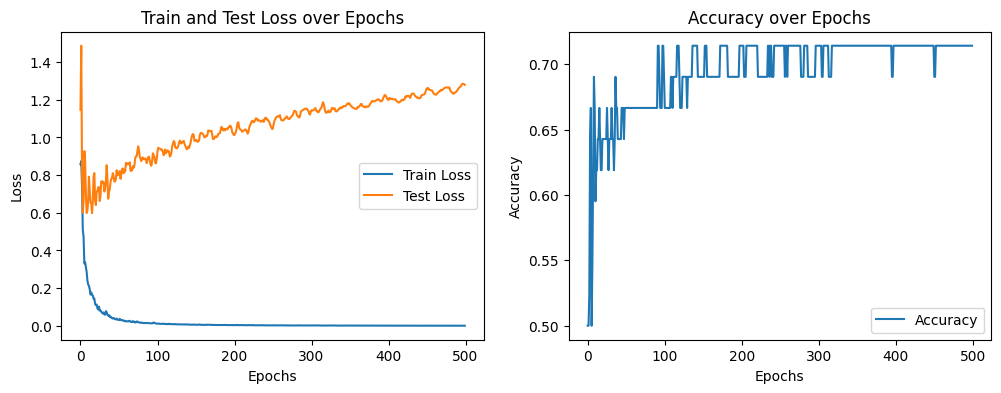

In [6]:
pretrained_model = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
pretrained_lora = deepcopy(pretrained_model)

pretrained_lora.fc = nn.Identity()

pretrained_dataset = precompute_features(pretrained_lora, north_dataset, device)
pretrained_dataloader = DataLoader(pretrained_dataset, batch_size=8, shuffle=True)

test_pretrained_dataset = precompute_features(pretrained_lora, test_dataset, device)
# The whole batch fits in memory so we might as well load it all at once
test_pretrained_dataloader = DataLoader(
    test_pretrained_dataset, batch_size=len(test_pretrained_dataset)
)

last_layer = nn.Sequential(nn.Linear(512, 2))

n_epochs = 500
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_layer.parameters(), lr=1e-3, weight_decay=1e-4)


train_loss_history, test_loss_history, accuracy_history = train(
    last_layer,
    pretrained_dataloader,
    test_pretrained_dataloader,
    loss_fn,
    optimizer,
    n_epochs,
    device,
)

torch.save(last_layer.state_dict(), "last_layer_finetune.pth")

plot_training(train_loss_history, test_loss_history, accuracy_history)

<div class="alert alert-info">The training process leverages transfer learning thanks to the meaningful features learned by the model when trained on ImageNet during its pretraining phase. Therefore the accuracy reached is higher than previously and goes up to 0.75</div>

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

<div class="alert alert-info">
LoRA (Low-Rank Adaptation) is a fine-tuning method for large pre-trained models that avoids updating all the parameters. Instead, it freezes the original weights and injects a trainable low-rank update into specific layers. Concretely, for a weight matrix W, the adapted weight is given by

$$W^*=W+BA$$

where $B$ and $A$ are low-rank matrices. This design dramatically reduces the number of parameters to be optimized, leading to efficient adaptation with lower computational overhead while still achieving strong performance on downstream tasks.

In our case, we apply LoRA to convolutions. The idea remains the same but instead of using matrices like in linear layers we use convultion filters. The idea is to replace a single filter with many parameters with a Down Conv filter followed by an Up Conv filter where:

- Down conv is similar to the original convlutional layer but has $r << C_{out}$ channels as output
- Up conv is a $C{out} \times r \times 1 \times 1$ convolutional filter that upsamples the number of channels of the output of DownConv
</div>


![Alternative text](drawing_lora.png)

### Baseline pretrained ResNet18

  2%|▏         | 1/50 [00:01<01:13,  1.51s/it]

Epoch 1, train loss: 0.4233, test loss: 0.6029, accuracy: 0.8095


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


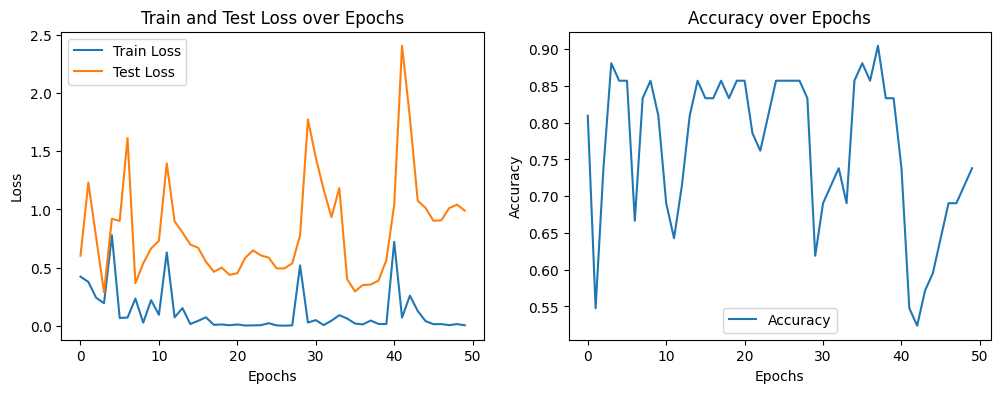

In [38]:
resnet = deepcopy(pretrained_model)
resnet.fc = nn.Linear(512, 2)

train_dataloader = DataLoader(north_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

n_epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=5e-4, weight_decay=1e-4)

train_loss_history, test_loss_history, accuracy_history = train(
    resnet, train_dataloader, test_dataloader, loss_fn, optimizer, n_epochs, device
)

plot_training(train_loss_history, test_loss_history, accuracy_history)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: matthieu-neau to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Initial accuracy: 0.5000


  0%|          | 1/200 [00:01<04:59,  1.50s/it]

Epoch 1, train loss: 0.7612, test loss: 4.1923, accuracy: 0.5000


  3%|▎         | 6/200 [00:05<02:37,  1.23it/s]

Epoch 6, train loss: 0.5351, test loss: 0.7888, accuracy: 0.4762


  6%|▌         | 11/200 [00:09<02:56,  1.07it/s]

Epoch 11, train loss: 0.5077, test loss: 0.7582, accuracy: 0.4762


  8%|▊         | 16/200 [00:13<02:26,  1.25it/s]

Epoch 16, train loss: 0.4142, test loss: 1.0069, accuracy: 0.5476


 10%|█         | 21/200 [00:17<02:10,  1.37it/s]

Epoch 21, train loss: 0.4446, test loss: 2.1444, accuracy: 0.4762


 13%|█▎        | 26/200 [00:21<02:11,  1.32it/s]

Epoch 26, train loss: 0.1753, test loss: 30.8787, accuracy: 0.5000


 16%|█▌        | 31/200 [00:24<02:00,  1.41it/s]

Epoch 31, train loss: 0.1282, test loss: 1.4405, accuracy: 0.7381


 18%|█▊        | 36/200 [00:28<02:00,  1.36it/s]

Epoch 36, train loss: 0.0990, test loss: 7.9370, accuracy: 0.5476


 20%|██        | 41/200 [00:31<01:51,  1.42it/s]

Epoch 41, train loss: 0.1701, test loss: 3.0022, accuracy: 0.6190


 23%|██▎       | 46/200 [00:35<01:49,  1.41it/s]

Epoch 46, train loss: 0.2039, test loss: 1.2239, accuracy: 0.7381


 26%|██▌       | 51/200 [00:39<01:57,  1.27it/s]

Epoch 51, train loss: 0.1234, test loss: 3.0294, accuracy: 0.6667


 28%|██▊       | 56/200 [00:43<01:48,  1.32it/s]

Epoch 56, train loss: 0.0292, test loss: 2.8193, accuracy: 0.6429


 30%|███       | 61/200 [00:46<01:40,  1.38it/s]

Epoch 61, train loss: 0.0423, test loss: 1.1249, accuracy: 0.7619


 33%|███▎      | 66/200 [00:50<01:48,  1.24it/s]

Epoch 66, train loss: 0.0027, test loss: 1.5665, accuracy: 0.7381


 36%|███▌      | 71/200 [00:54<01:35,  1.34it/s]

Epoch 71, train loss: 0.0131, test loss: 1.6197, accuracy: 0.7143


 38%|███▊      | 76/200 [00:58<01:30,  1.36it/s]

Epoch 76, train loss: 0.0022, test loss: 1.3429, accuracy: 0.7857


 40%|████      | 81/200 [01:01<01:27,  1.35it/s]

Epoch 81, train loss: 0.0022, test loss: 2.6568, accuracy: 0.7143


 43%|████▎     | 86/200 [01:05<01:23,  1.36it/s]

Epoch 86, train loss: 0.0107, test loss: 1.7342, accuracy: 0.7619


 46%|████▌     | 91/200 [01:09<01:23,  1.30it/s]

Epoch 91, train loss: 0.0016, test loss: 1.6926, accuracy: 0.7143


 48%|████▊     | 96/200 [01:13<01:21,  1.28it/s]

Epoch 96, train loss: 0.0005, test loss: 2.1630, accuracy: 0.6905


 50%|█████     | 101/200 [01:17<01:15,  1.30it/s]

Epoch 101, train loss: 0.0007, test loss: 2.2683, accuracy: 0.6429


 53%|█████▎    | 106/200 [01:21<01:16,  1.23it/s]

Epoch 106, train loss: 0.0018, test loss: 2.5034, accuracy: 0.6667


 56%|█████▌    | 111/200 [01:25<01:08,  1.30it/s]

Epoch 111, train loss: 0.0017, test loss: 1.6465, accuracy: 0.7857


 58%|█████▊    | 116/200 [01:28<01:04,  1.30it/s]

Epoch 116, train loss: 0.0012, test loss: 5.0538, accuracy: 0.5952


 60%|██████    | 121/200 [01:32<01:00,  1.31it/s]

Epoch 121, train loss: 0.0021, test loss: 3.1665, accuracy: 0.7143


 63%|██████▎   | 126/200 [01:36<00:54,  1.35it/s]

Epoch 126, train loss: 0.1403, test loss: 1.6114, accuracy: 0.7143


 66%|██████▌   | 131/200 [01:40<00:55,  1.25it/s]

Epoch 131, train loss: 0.0290, test loss: 1.3057, accuracy: 0.7381


 68%|██████▊   | 136/200 [01:44<00:52,  1.22it/s]

Epoch 136, train loss: 0.0033, test loss: 1.7191, accuracy: 0.7619


 70%|███████   | 141/200 [01:48<00:45,  1.29it/s]

Epoch 141, train loss: 0.0028, test loss: 1.5571, accuracy: 0.7857


 73%|███████▎  | 146/200 [01:52<00:47,  1.14it/s]

Epoch 146, train loss: 0.0009, test loss: 1.7562, accuracy: 0.7857


 76%|███████▌  | 151/200 [01:56<00:39,  1.24it/s]

Epoch 151, train loss: 0.0009, test loss: 2.1239, accuracy: 0.7857


 78%|███████▊  | 156/200 [02:00<00:36,  1.21it/s]

Epoch 156, train loss: 0.0005, test loss: 2.5549, accuracy: 0.6905


 80%|████████  | 161/200 [02:05<00:33,  1.15it/s]

Epoch 161, train loss: 0.0011, test loss: 2.0449, accuracy: 0.7857


 83%|████████▎ | 166/200 [02:09<00:29,  1.15it/s]

Epoch 166, train loss: 0.0003, test loss: 1.8730, accuracy: 0.7857


 86%|████████▌ | 171/200 [02:15<00:30,  1.05s/it]

Epoch 171, train loss: 0.0004, test loss: 1.8494, accuracy: 0.7857


 88%|████████▊ | 176/200 [02:20<00:24,  1.01s/it]

Epoch 176, train loss: 0.0002, test loss: 1.7719, accuracy: 0.7619


 90%|█████████ | 181/200 [02:26<00:22,  1.17s/it]

Epoch 181, train loss: 0.0171, test loss: 2.0239, accuracy: 0.7143


 93%|█████████▎| 186/200 [02:31<00:15,  1.11s/it]

Epoch 186, train loss: 0.0055, test loss: 1.3628, accuracy: 0.7857


 96%|█████████▌| 191/200 [02:37<00:10,  1.15s/it]

Epoch 191, train loss: 0.0407, test loss: 2.4549, accuracy: 0.6429


 98%|█████████▊| 196/200 [02:44<00:05,  1.42s/it]

Epoch 196, train loss: 0.0355, test loss: 1.4292, accuracy: 0.5714


100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


accuracy,▂▁▁▁▁▁▁▂▃▇▆▅▅▆▇▇▆██▇▇▇▆▇▅▅█▇▅▃▄▇▇█▇██▇█▄
grad_norm,▂▂▁▂▁▁▂▂▂▁▂▃▄▃▄▁▁▂▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▂▁█▁▁▁
test_loss,█▁▁▁▁▁▁▃▁▄▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▂▂▁▁▂▁
train_loss,██▃▂▂▄▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▄
accuracy,0.61905
grad_norm,2.20365
test_loss,7.54401
train_loss,0.02459


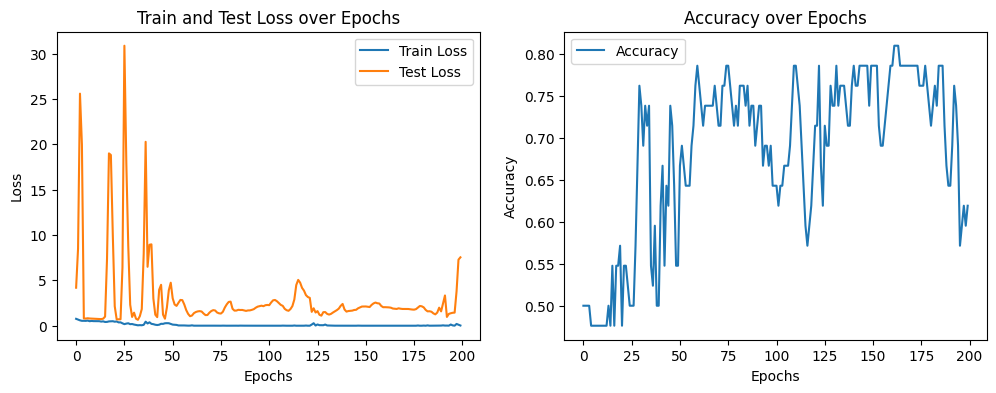

In [ ]:
from utils import build_lora_resnet
from torchinfo import summary

from utils import train_lora

pretrained_resnet = deepcopy(pretrained_model)
pretrained_lora = deepcopy(pretrained_model)
build_lora_resnet(pretrained_lora, r=4, alpha=4)

# pretrained_lora.state_dict()["layer4.1.conv2.upConv.weight"].requires_grad

pretrained_lora.fc = nn.Linear(512, 2)
pretrained_resnet.fc = nn.Linear(512, 2)

for param in pretrained_resnet.parameters():
    param.requires_grad = False
for param in pretrained_lora.parameters():
    param.requires_grad = True

train_dataloader = DataLoader(north_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=42)

# old_weights = pretrained_resnet.layer1[0].conv1.weight.data.clone().to(device)
# old_weights2 = pretrained_lora.layer1[0].conv1.downConv.weight.data.clone().to(device)

optimizer = torch.optim.Adam(pretrained_lora.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 200

train_loss_history, test_loss_history, accuracy_history = train_lora(
    pretrained_model=pretrained_resnet,
    lora_model=pretrained_lora,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
)

# # new_weights = pretrained_resnet.layer1[0].conv1.weight.data.clone().to(device)
# # new_weights2 = pretrained_lora.layer1[0].conv1.downConv.weight.data.clone().to(device)

# # print(torch.allclose(old_weights, new_weights))
# # print(torch.allclose(old_weights2, new_weights2))

plot_training(train_loss_history, test_loss_history, accuracy_history)
# # torch.save(lora_model.state_dict(), "lora_resnet.pth")

In [ ]:
from torchinfo import summary
from utils import inflate_lora
from utils import merge_models

lora_resnet2 = deepcopy(pretrained_lora)
inflate_lora(lora_resnet2)
merge_models(pretrained_resnet, lora_resnet2, device)
summary(lora_resnet2)
assert isinstance(pretrained_resnet, models.ResNet)

<div class="alert alert-info">
Notice that the training are quite unstable but stabilize after a certain number of epochs. We tried to gain insight on the runs by logging everything: https://wandb.ai/matthieu-neau/lora?nw=nwusermatthieuneau 

Namely, we noticed spikes in the **gradient norm** when training and attempted to clip them to stablize but it did not improved results.

We also tried lowering the **learning rate** and varying the **batch size**, hoping to obtain a less erratic behvior but it did not work out either.

Overall, we reach a top accuracy of 80%, that is slightly better than what we obtained in the previous question.
</div>

## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

![Alternative text](cutmix.png)

In [20]:
## Data Augmentation
from torchvision.transforms import v2
from torch.utils.data import default_collate
import matplotlib.pyplot as plt


augmentation_transform = v2.Compose(
    [
        # v2.RandomResizedCrop(224),
        # v2.RandomHorizontalFlip(p=0.5),
        # v2.RandomRotation(15),
        # v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        v2.ToTensor(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

augmented_dataset = datasets.ImageFolder(
    "data/TP4_images/north_dataset_sample", transform=augmentation_transform
)

cutmix = v2.CutMix(num_classes=2)
mixup = v2.MixUp(num_classes=2)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])


def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))


augmented_dataloader = DataLoader(
    augmented_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(test_dataset, batch_size=42)

# for images, labels in augmented_dataloader:
#     print(f"before CutMix/MixUp: {images.shape = }, {labels}")
#     # images, labels = cutmix_or_mixup(images, labels)
#     print(f"after CutMix/MixUp: {images.shape = }, {labels}")
#     plt.imshow(images[0].squeeze(0).permute(1, 2, 0))
#     break

Initial accuracy: 0.5000


  0%|          | 1/200 [00:01<03:31,  1.07s/it]

Epoch 1, train loss: 0.7159, test loss: 8.3975, accuracy: 0.5000


  3%|▎         | 6/200 [00:04<02:13,  1.46it/s]

Epoch 6, train loss: 0.6175, test loss: 0.7126, accuracy: 0.5000


  6%|▌         | 11/200 [00:07<02:06,  1.50it/s]

Epoch 11, train loss: 0.6079, test loss: 0.7028, accuracy: 0.5000


  8%|▊         | 16/200 [00:10<01:55,  1.59it/s]

Epoch 16, train loss: 0.6160, test loss: 0.6498, accuracy: 0.5714


 10%|█         | 21/200 [00:13<01:52,  1.60it/s]

Epoch 21, train loss: 0.4804, test loss: 0.6362, accuracy: 0.6905


 13%|█▎        | 26/200 [00:17<01:54,  1.52it/s]

Epoch 26, train loss: 0.3888, test loss: 0.6570, accuracy: 0.6667


 16%|█▌        | 31/200 [00:20<01:46,  1.59it/s]

Epoch 31, train loss: 0.4301, test loss: 0.6434, accuracy: 0.5476


 18%|█▊        | 36/200 [00:23<01:45,  1.56it/s]

Epoch 36, train loss: 0.3981, test loss: 0.6133, accuracy: 0.6190


 20%|██        | 41/200 [00:26<01:39,  1.60it/s]

Epoch 41, train loss: 0.3980, test loss: 1.3924, accuracy: 0.4762


 23%|██▎       | 46/200 [00:29<01:39,  1.55it/s]

Epoch 46, train loss: 0.4437, test loss: 0.8362, accuracy: 0.5238


 26%|██▌       | 51/200 [00:33<01:35,  1.56it/s]

Epoch 51, train loss: 0.3699, test loss: 0.7007, accuracy: 0.5476


 28%|██▊       | 56/200 [00:36<01:31,  1.57it/s]

Epoch 56, train loss: 0.3963, test loss: 3.9395, accuracy: 0.5000


 30%|███       | 61/200 [00:39<01:29,  1.55it/s]

Epoch 61, train loss: 0.3426, test loss: 7.4681, accuracy: 0.5000


 33%|███▎      | 66/200 [00:42<01:25,  1.58it/s]

Epoch 66, train loss: 0.3168, test loss: 9.9528, accuracy: 0.5000


 36%|███▌      | 71/200 [00:45<01:22,  1.55it/s]

Epoch 71, train loss: 0.6718, test loss: 7.7148, accuracy: 0.4762


 38%|███▊      | 76/200 [00:49<01:21,  1.51it/s]

Epoch 76, train loss: 0.3319, test loss: 2.3195, accuracy: 0.5000


 40%|████      | 81/200 [00:52<01:16,  1.56it/s]

Epoch 81, train loss: 0.3794, test loss: 1.6113, accuracy: 0.5000


 43%|████▎     | 86/200 [00:55<01:14,  1.53it/s]

Epoch 86, train loss: 0.3204, test loss: 3.5458, accuracy: 0.5000


 46%|████▌     | 91/200 [00:59<01:12,  1.50it/s]

Epoch 91, train loss: 0.3121, test loss: 3.7342, accuracy: 0.5000


 48%|████▊     | 96/200 [01:02<01:06,  1.56it/s]

Epoch 96, train loss: 0.4317, test loss: 0.6666, accuracy: 0.7381


 50%|█████     | 101/200 [01:05<01:04,  1.53it/s]

Epoch 101, train loss: 0.3620, test loss: 1.0865, accuracy: 0.5000


 53%|█████▎    | 106/200 [01:08<01:00,  1.56it/s]

Epoch 106, train loss: 0.4086, test loss: 4.3723, accuracy: 0.5000


 56%|█████▌    | 111/200 [01:11<00:57,  1.55it/s]

Epoch 111, train loss: 0.3587, test loss: 1.1891, accuracy: 0.5952


 58%|█████▊    | 116/200 [01:15<00:55,  1.51it/s]

Epoch 116, train loss: 0.3302, test loss: 0.6523, accuracy: 0.6190


 60%|██████    | 121/200 [01:18<00:50,  1.56it/s]

Epoch 121, train loss: 0.4362, test loss: 0.6209, accuracy: 0.6905


 63%|██████▎   | 126/200 [01:21<00:49,  1.49it/s]

Epoch 126, train loss: 0.3249, test loss: 4.3794, accuracy: 0.5000


 66%|██████▌   | 131/200 [01:25<00:46,  1.47it/s]

Epoch 131, train loss: 0.2863, test loss: 0.7880, accuracy: 0.5952


 68%|██████▊   | 136/200 [01:28<00:41,  1.52it/s]

Epoch 136, train loss: 0.2032, test loss: 0.5278, accuracy: 0.7143


 70%|███████   | 141/200 [01:31<00:39,  1.48it/s]

Epoch 141, train loss: 0.3512, test loss: 4.2525, accuracy: 0.5000


 73%|███████▎  | 146/200 [01:35<00:35,  1.54it/s]

Epoch 146, train loss: 0.3361, test loss: 0.4060, accuracy: 0.8095


 76%|███████▌  | 151/200 [01:38<00:32,  1.52it/s]

Epoch 151, train loss: 0.4082, test loss: 0.5093, accuracy: 0.6905


 78%|███████▊  | 156/200 [01:41<00:29,  1.50it/s]

Epoch 156, train loss: 0.2298, test loss: 0.7902, accuracy: 0.5714


 80%|████████  | 161/200 [01:45<00:25,  1.52it/s]

Epoch 161, train loss: 0.3077, test loss: 0.6866, accuracy: 0.5952


 83%|████████▎ | 166/200 [01:48<00:23,  1.44it/s]

Epoch 166, train loss: 0.3543, test loss: 0.4871, accuracy: 0.7857


 86%|████████▌ | 171/200 [01:51<00:18,  1.54it/s]

Epoch 171, train loss: 0.3934, test loss: 1.9435, accuracy: 0.5000


 88%|████████▊ | 176/200 [01:55<00:16,  1.49it/s]

Epoch 176, train loss: 0.2628, test loss: 1.1824, accuracy: 0.5714


 90%|█████████ | 181/200 [01:58<00:12,  1.50it/s]

Epoch 181, train loss: 0.3927, test loss: 0.5589, accuracy: 0.7381


 93%|█████████▎| 186/200 [02:01<00:09,  1.47it/s]

Epoch 186, train loss: 0.3539, test loss: 0.4307, accuracy: 0.8571


 96%|█████████▌| 191/200 [02:05<00:05,  1.53it/s]

Epoch 191, train loss: 0.2145, test loss: 0.4822, accuracy: 0.7857


 98%|█████████▊| 196/200 [02:08<00:02,  1.49it/s]

Epoch 196, train loss: 0.3671, test loss: 0.4065, accuracy: 0.8810


100%|██████████| 200/200 [02:11<00:00,  1.53it/s]


accuracy,▂▂▂▂▂▅▅▄▂▄▅▂▂▂▂▁▂▆▂▁▃▂▂▂▃▂▂▆▄▂▆▃▆█▄▂▃▄▇▇
grad_norm,█▃█▁▂▁▂▃▃▂▂▂▂▄▂▂▂▂▅▁▆▂▃▅▁▆▂▃▂▂▂▁▂▁▂▃▃▁▂▂
test_loss,▄██▁▁▁▁▁▁▁▁▁▁▄▅▄▄▁▁▂▂▁▁▁▁▃▁▃▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,▆▆▇▆▆█▅▅▄▆▆█▅▃▇▃▃▁▃▅▃▃▅▃▁▃▄▇▄▆▅▃▂▃▄▄▂▂▁▅
accuracy,0.7381
grad_norm,5.17102
test_loss,0.73346
train_loss,0.28147


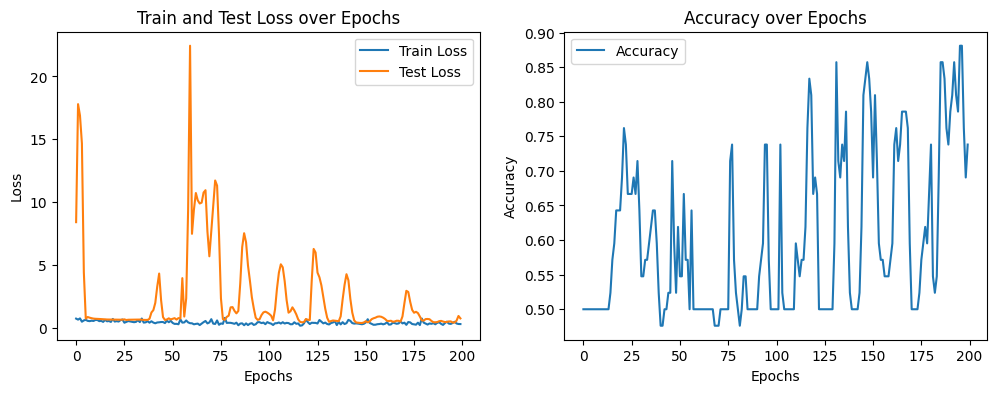

In [21]:
pretrained_resnet = deepcopy(pretrained_model)
pretrained_lora = deepcopy(pretrained_model)
pretrained_resnet.fc = nn.Linear(512, 2)
pretrained_lora.fc = nn.Linear(512, 2)
build_lora_resnet(pretrained_lora, r=4, alpha=4)

for param in pretrained_resnet.parameters():
    param.requires_grad = False
for param in pretrained_lora.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(pretrained_lora.parameters(), lr=1e-3)
n_epochs = 200
loss_fn = nn.CrossEntropyLoss()

train_loss_history, test_loss_history, accuracy_history = train_lora(
    pretrained_model=pretrained_resnet,
    lora_model=pretrained_lora,
    test_dataloader=test_dataloader,
    train_dataloader=augmented_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
)


plot_training(train_loss_history, test_loss_history, accuracy_history)

# assert isinstance(lora_model, models.ResNet)

In [ ]:
# Done in place
merge_models(pretrained_lora, pretrained_resnet, device)

In [36]:
torch.save(pretrained_lora.state_dict(), "daug_resnet.pth")

In [37]:
# Checking that the merged model can be loaded and is of the correct type
lora_daug_model = torch.load("daug_resnet.pth")
assert isinstance(pretrained_lora, models.ResNet)

## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 